In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import morphs
from morphs.data.derivative import f_map

from sklearn.model_selection import LeaveOneGroupOut, cross_validate
logo = LeaveOneGroupOut()
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

from xgboost import XGBClassifier
xgb = XGBClassifier()

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
ddf = morphs.load.derivative_df()

In [3]:
# NBVAL_SKIP
mean_scores = {}
for order in range(7):
    ys = ddf[order][ddf[order].str[0].notna()].map(f_map)
    ys = np.array([y for y in ys.values])
    labels = ddf["morph_dim"][ddf[order].str[0].notna()].values
    groups = ddf["block_path"][ddf[order].str[0].notna()].values
    scores = cross_validate(lr, ys, y=labels, cv=logo.split(ys, labels, groups), n_jobs=-1)
    mean_scores[order] = scores['test_score'].mean()

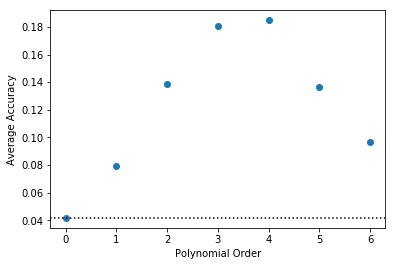

In [4]:
# NBVAL_SKIP
ax = plt.gca()
_ = ax.plot(range(7), [mean_scores[order] for order in range(7)], "o")
_ = ax.axhline(1 / 24, linestyle=":", color="k")
_ = ax.set_ylabel("Average Accuracy")
_ = ax.set_xlabel("Polynomial Order")

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
# NBVAL_SKIP
xgb_mean_scores = {}
for order in range(7):
    ys = ddf[order][ddf[order].str[0].notna()].map(f_map)
    ys = np.array([y for y in ys.values])
    labels = ddf["morph_dim"][ddf[order].str[0].notna()].values
    groups = ddf["block_path"][ddf[order].str[0].notna()].values
    scores = cross_validate(xgb, ys, y=labels, cv=logo.split(ys, labels, groups), n_jobs=-1)
    xgb_mean_scores[order] = scores['test_score'].mean()

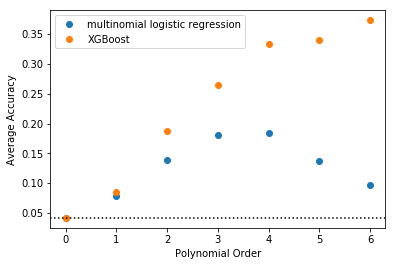

In [7]:
# NBVAL_SKIP
ax = plt.gca()
_ = ax.plot(range(7), [mean_scores[order] for order in range(7)], "o", label="multinomial logistic regression")
_ = ax.plot(range(7), [xgb_mean_scores[order] for order in range(7)], "o", label="XGBoost")
_ = ax.axhline(1 / 24, linestyle=":", color="k")
_ = ax.set_ylabel("Average Accuracy")
_ = ax.set_xlabel("Polynomial Order")
_ = ax.legend()